# Transistor math

In [89]:
import matplotlib.pyplot as plt  # importar a bilioteca pyplot para fazer gráficos
import matplotlib.ticker as plticker
import matplotlib.colors as mcolors
import numpy as np   # importar a biblioteca Numpy para lidar com matrizes
import pandas as pd   # importa bilioteca pandas para  lidar com processamento de dados
import os
from scipy import optimize
import SchemDraw as schem
import SchemDraw.elements as e
import matplotlib.colors as mcolors
from myst_nb import glue

In [25]:
def draw_transistor(unit_size, **kwargs):
    d = schem.Drawing(unit=unit_size,**kwargs)
    VB = d.add(e.DOT_OPEN, label='$V_{BB}$')
    RB = d.add(e.RES, d='right',label='$R_{B}$')
    bjt = d.add(e.BJT_NPN_C, d='right')
    #----
    Rc = d.add(e.RES, d='up', xy=bjt.collector, label='$R_C$')
    Vcc = d.add(e.DOT_OPEN, label='$V_{CC}$')
    #RE = d.add(e.RES, d='down', xy=bjt.emitter, label='$R_E$')
    gnd = d.add(e.GND,xy=bjt.emitter)
    return d
def plot_load_lines_transistor(Vcc=10,Rc=100,Vbb=1,Rb=1000):
    def Ib(Vbe,Ies=3*1e-14):
        β = 39.6 #[1/V]
        return Ies*(np.exp(β*Vbe-1))
    def Ic(Vce,Ies=300*1e-14, VEA = 200):
        β = 39.6 #[1/V]
        #VEA = 40 # Early Voltage 
        βr = 0.0001
        αr = βr/(1+βr)
        Vbc = Vbe - Vce
        return Ies*( np.exp(β*Vbe-1)*(1+(Vbe-Vbc)/VEA) - 1/αr*(np.exp(β*Vbc)-1))
    def Vdiodo(I,Is=1e-13):
        β = 39.6 #[1/V]
        return 1/β*np.log(1+I/Is)
    def KVL(V,Vin,R):
        return Vin-R*Ic(V)-V
    def KVLb(V,Vin,R):
        return Vin-R*Ib(V)-V
    def Vdiodo(Vin,V0,R):
        return optimize.brentq(KVL, -1.1*V0, 1.1*V0, args = (Vin,R))
    def Vdiodob(Vin,V0,R):
        return optimize.brentq(KVLb, -1.1*V0, 1.1*V0, args = (Vin,R))
    #return fixed_point(lambda x: Vin-R*Idiodo(x)-x,0.6,args=(1.0,100))
    npt=50
    Vin = Vcc
    Vb0 = Vbb
    #---
    fig_size = (18,6)
    fig,ax = plt.subplots(1,3,figsize=fig_size)
    #------------------
    ax0 = ax[0]
    draw_transistor(2.5).draw(ax=ax0)
    ax0.set_aspect('equal')
    #DivTensao([e.RES,'R'],[e.DIODE,'D'],fonte = [False,e.SOURCE_V]).draw(ax=ax0)
    ax0.axes.get_xaxis().set_visible(False)
    ax0.axes.get_yaxis().set_visible(False)
    ax0.set_frame_on(False)
    ax0.set_xticklabels(())
    ax0.set_yticklabels(())
    ax0.get_figure().set_size_inches(fig_size[0]*0.7,fig_size[1])
    
    #------------------
    #BASE
    Vin_min, Vin_max = 0,2 # [V]
    I_min, I_max = 0,1500e-6 # [μA]
    I=np.linspace(I_min,I_max,npt)
    V = np.linspace(0,1,npt)
    Vlhs = Vb0-Rb*I # equação LHS
    ax0 = ax[1]
    ax0.plot(Vlhs,I*1e6,label = r'$V_{BB}-R_B I_B-V_{BE}(I_B)=0$')
    ax0.plot(V, Ib(V)*1e6, c='r',lw=2, label = r'$I_B(V_{BE})$',zorder=4)
    #solução para corrente e tensão
    Vd = Vdiodob(Vb0,Vb0,Rb) # equação RHS
    Id = Ib(Vd)
    ax0.axhline(1e6*Id, c='k', ls = '--',zorder=0)
    ax0.axvline(Vd, c='k', ls = '--',zorder=0)
    lab =  r'$I_B$,$V_{BE}$'+'={:2.0f} μA, {:2.0f} mV'.format(1e6*Id,1e3*Vd)
    ax0.scatter(Vd,1e6*Id, c='r', marker='o', s=100, label=lab)
    #---
    #lab = '$V_{aberto}$'+'={} V'.format(Vb0)
    ax0.scatter(Vb0,0, color='b', marker='o', s=70,zorder=3)
    #lab = '$I_{curto}$'+'={:2.1f} mA'.format(1e6*Vin/Rb)
    ax0.scatter(0,Vb0/Rb*1e6, color='b', marker='P', s=70,zorder=3)
    #---
    #eixos x-y
    ax0.axhline(0, color='k', linestyle = '-',lw=2)
    ax0.axvline(0, color='k', linestyle = '-',lw=2)
    #-----------------------
    ax0.set_xlabel('Tensão, $V_{BE}$ (V)')
    ax0.set_ylabel('Corrente, $I_B$ (μA)')
    ax0.set_xlim([Vin_min,Vin_max])
    ax0.set_ylim(np.array([I_min,I_max])*1e6)
    ax0.legend(loc = 'lower center',bbox_to_anchor=[0.5,1.0])
    ax0.grid(True,which='both')
    #------------------
    #COLETOR_EMISSOR
    Vbe = Vd # from previous
    #limites dos eixos
    Vin_min, Vin_max = -1,10 # [V]
    I_min, I_max = -1,100 # [mA]
    #-------------
    V = np.linspace(0,10,npt)
    #I = Idiodo(V)  # equação diodo
    I=np.linspace(I_min,I_max,npt)
    #----------------------
    Vlhs = Vin-Rc*I # equação LHS
    #Vlhs = Vin-R*Id # equação LHS
    #Vrhs = Vdiodo(Vin,Vin,R) # equação RHS
    
    
    ax0 = ax[2]
    ax0.plot(Vlhs,I*1e3, label = r'$V_{CC}-R_C I_C-V_{CE}(I_C)=0$')
    ax0.plot(V, Ic(V)*1e3, c='r',lw=2,label = r'$I_C(V_{CE})$',zorder=4)
    #---
    #eixos x-y
    ax0.axhline(0, color='k', linestyle = '-',lw=2)
    ax0.axvline(0, color='k', linestyle = '-',lw=2)
    #---
    #lab = '$V_{aberto}$'+'={} V'.format(Vin)
    ax0.scatter(Vin,0, color='b', marker='o', s=70,zorder=3)
    #lab = '$I_{curto}$'+'={:2.1f} mA'.format(1e3*Vin/Rc)
    ax0.scatter(0,Vin/Rc*1e3, color='b', marker='P', s=70,zorder=3)
    #solução para corrente e tensão
    Vd = Vdiodo(Vin,Vin,Rc) # equação RHS
    Id = Ic(Vd)
    ax0.axhline(1e3*Id, c='k', ls = '--',zorder=0)
    ax0.axvline(Vd, c='k', ls = '--',zorder=0)
    lab = r'$I_C$,$V_{CE}$'+'={:2.0f} mA, {:2.0f} V'.format(1e3*Id,Vd)
    ax0.scatter(Vd,1e3*Id, c='r', marker='o', s=100, label=lab)
    #-----------------------
    ax0.set_xlabel('Tensão, $V_{CE}$ (V)')
    ax0.set_ylabel('Corrente, $I_C$ (mA)')
    ax0.set_xlim([Vin_min,Vin_max])
    ax0.set_ylim([I_min,I_max])
    ax0.legend(loc = 'lower center',bbox_to_anchor=[0.5,1.0])
    ax0.grid(True,which='both')
    ax0.xaxis.set_major_locator(plticker.MultipleLocator(2))
    ax0.yaxis.set_major_locator(plticker.MultipleLocator(10)) 
    
    #ax0.xaxis.set_major_locator(plticker.MultipleLocator(1))
    #ax0.yaxis.set_major_locator(plticker.MultipleLocator(2)) 
    plt.tight_layout()
    return

In [112]:
def plot_ic_curves_transistor(Vcc=10,Rc=100,Vbb_vec=np.arange(0.6,1.8,0.3),Rb=1000):
    def Ib(Vbe,Ies=3*1e-14):
        β = 39.6 #[1/V]
        return Ies*(np.exp(β*Vbe-1))
    def Ic(Vce,Ies=300*1e-14, VEA = 200):
        β = 39.6 #[1/V]
        #VEA = 40 # Early Voltage 
        βr = 0.0001
        αr = βr/(1+βr)
        Vbc = Vbe - Vce
        return Ies*( np.exp(β*Vbe-1)*(1+(Vbe-Vbc)/VEA) - 1/αr*(np.exp(β*Vbc)-1))
    def Vdiodo(I,Is=1e-13):
        β = 39.6 #[1/V]
        return 1/β*np.log(1+I/Is)
    def KVL(V,Vin,R):
        return Vin-R*Ic(V)-V
    def KVLb(V,Vin,R):
        return Vin-R*Ib(V)-V
    def Vdiodo(Vin,V0,R):
        return optimize.brentq(KVL, -1.1*V0, 1.1*V0, args = (Vin,R))
    def Vdiodob(Vin,V0,R):
        return optimize.brentq(KVLb, -1.1*V0, 1.1*V0, args = (Vin,R))
    #return fixed_point(lambda x: Vin-R*Idiodo(x)-x,0.6,args=(1.0,100))
    fig_size = (18,6)
    fig,ax = plt.subplots(1,3,figsize=fig_size)
    colors=list(mcolors.TABLEAU_COLORS.keys())
    for ii,Vbb in enumerate(Vbb_vec):
        npt=50
        Vin = Vcc
        Vb0 = Vbb
        #---

        #------------------
        ax0 = ax[0]
        draw_transistor(2.5).draw(ax=ax0)
        ax0.set_aspect('equal')
        #DivTensao([e.RES,'R'],[e.DIODE,'D'],fonte = [False,e.SOURCE_V]).draw(ax=ax0)
        ax0.axes.get_xaxis().set_visible(False)
        ax0.axes.get_yaxis().set_visible(False)
        ax0.set_frame_on(False)
        ax0.set_xticklabels(())
        ax0.set_yticklabels(())
        ax0.get_figure().set_size_inches(fig_size[0]*0.7,fig_size[1])

        #------------------
        #BASE
        Vin_min, Vin_max = 0,1.5 # [V]
        I_min, I_max = 0,1500e-6 # [μA]
        I=np.linspace(I_min,I_max,npt)
        V = np.linspace(0,1,npt)
        Vlhs = Vb0-Rb*I # equação LHS
        ax0 = ax[1]
        if ii==0: 
            ax0.plot(Vlhs,I*1e6,c=colors[ii],label = r'$V_{BB}-R_B I_B-V_{BE}(I_B)=0$')
            ax0.plot(V, Ib(V)*1e6, c='gray',lw=2, label = r'$I_B(V_{BE})$',zorder=4)
        else: 
            ax0.plot(Vlhs,I*1e6,c=colors[ii]) 
        #solução para corrente e tensão
        Vd = Vdiodob(Vb0,Vb0,Rb) # equação RHS
        Id = Ib(Vd)
#         ax0.axhline(1e6*Id, c='k', ls = '--',zorder=0)
#         ax0.axvline(Vd, c='k', ls = '--',zorder=0)
        lab =  r'$I_B$,$V_{BE}$'+'={:2.0f} μA, {:2.0f} mV'.format(1e6*Id,1e3*Vd)
        ax0.scatter(Vd,1e6*Id, c=colors[ii], marker='o', s=100)
        #---
        #lab = '$V_{aberto}$'+'={} V'.format(Vb0)
        ax0.scatter(Vb0,0, color='b', marker='o', s=70,zorder=3)
        #lab = '$I_{curto}$'+'={:2.1f} mA'.format(1e6*Vin/Rb)
        ax0.scatter(0,Vb0/Rb*1e6, color='b', marker='P', s=70,zorder=3)
        #---
        #eixos x-y
        ax0.axhline(0, color='k', linestyle = '-',lw=2)
        ax0.axvline(0, color='k', linestyle = '-',lw=2)
        #-----------------------
        ax0.set_xlabel('Tensão, $V_{BE}$ (V)')
        ax0.set_ylabel('Corrente, $I_B$ (μA)')
        ax0.set_xlim([Vin_min,Vin_max])
        ax0.set_ylim(np.array([I_min,I_max])*1e6)
        ax0.legend(loc = 'lower center',bbox_to_anchor=[0.5,1.0])
        ax0.grid(True,which='both')


        ax0 = ax[2]
        #------------------
        #COLETOR_EMISSOR
        Vbe = Vd # from previous
        #limites dos eixos
        Vin_min, Vin_max = -1,10 # [V]
        I_min, I_max = -1,100 # [mA]
        #-------------
        V = np.linspace(0,10,npt)
        #I = Idiodo(V)  # equação diodo
        I=np.linspace(I_min,I_max,npt)
        #----------------------
        Vlhs = Vin-Rc*I # equação LHS
        #Vlhs = Vin-R*Id # equação LHS
        #Vrhs = Vdiodo(Vin,Vin,R) # equação RHS


        if ii==0:     
            ax0.plot(Vlhs,I*1e3,c='gray' ,label = r'$V_{CC}-R_C I_C-V_{CE}(I_C)=0$')
            ax0.plot(V, Ic(V)*1e3, c=colors[ii],lw=2,label = r'$I_C(V_{CE})$',zorder=4)
        else:
            #ax0.plot(Vlhs,I*1e3)
            ax0.plot(V, Ic(V)*1e3,c=colors[ii],lw=2,zorder=4)            
        #---
        #eixos x-y
        ax0.axhline(0, color='k', linestyle = '-',lw=2)
        ax0.axvline(0, color='k', linestyle = '-',lw=2)
        #---
        #lab = '$V_{aberto}$'+'={} V'.format(Vin)
        ax0.scatter(Vin,0, color='b', marker='o', s=70,zorder=3)
        #lab = '$I_{curto}$'+'={:2.1f} mA'.format(1e3*Vin/Rc)
        ax0.scatter(0,Vin/Rc*1e3, color='b', marker='P', s=70,zorder=3)
        #solução para corrente e tensão
        Vd = Vdiodo(Vin,Vin,Rc) # equação RHS
        Id = Ic(Vd)
#         ax0.axhline(1e3*Id, c='k', ls = '--',zorder=0)
#         ax0.axvline(Vd, c='k', ls = '--',zorder=0)
        lab = r'$I_C$,$V_{CE}$'+'={:2.0f} mA, {:2.0f} V'.format(1e3*Id,Vd)
        ax0.scatter(Vd,1e3*Id, c=colors[ii], marker='o', s=100)
        #-----------------------
        ax0.set_xlabel('Tensão, $V_{CE}$ (V)')
        ax0.set_ylabel('Corrente, $I_C$ (mA)')
        ax0.set_xlim([Vin_min,Vin_max])
        ax0.set_ylim([I_min,I_max])
        ax0.legend(loc = 'lower center',bbox_to_anchor=[0.5,1.0])
        ax0.grid(True,which='both')
        ax0.xaxis.set_major_locator(plticker.MultipleLocator(2))
        ax0.yaxis.set_major_locator(plticker.MultipleLocator(10)) 

        #ax0.xaxis.set_major_locator(plticker.MultipleLocator(1))
        #ax0.yaxis.set_major_locator(plticker.MultipleLocator(2)) 
    plt.tight_layout()
    return fig

[0.4 0.8 1.2 1.6]


None

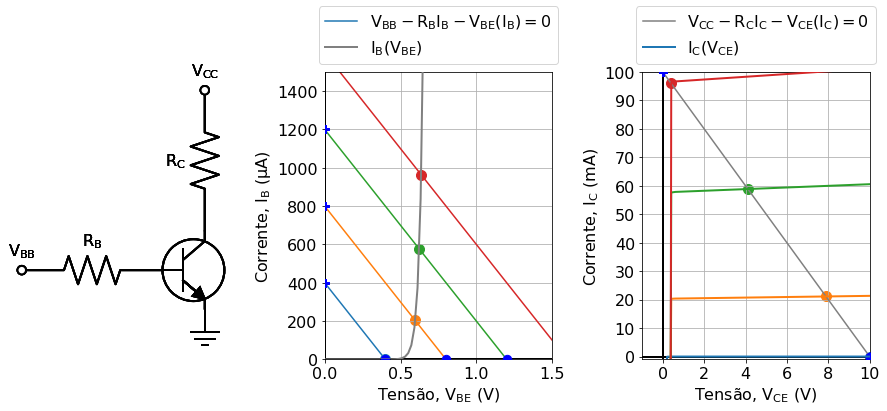

In [113]:
vbbvec=np.arange(0.4,1.8,0.4)
fig = plot_ic_curves_transistor(Vcc=10,Rc=100,Vbb_vec=vbbvec,Rb=1000)
glue("fig_ic_ib_curves",fig,display=False)
glue("vbbvec",print(vbbvec))

In order to solve the simple transistor circuit illustrated above, we must write Kirchhoff's law for both base and collector meshes:

For the base mesh,

$$ V_{BB}-R_B I_B-V_{BE}(I_B)=0$$ (eq:base_kcl)

For the colector mesh,

$$ V_{CC}-R_C I_C - V_{CE}(I_C)=0$$ (eq:collector_kcl)

In the active regime of the transistor ($V_{BE}\geq 0.7$ V and $V_{CE}>V{BE}$), a simple relation is valid between $I_C$ and $I_B$ that couples base and collector meshes,

$$I_C = \beta I_B$$ (eq:ic_ib)

Althout it might seem rather straightforward to solve  {eq}`eq:base_kcl`,{eq}`eq:collector_kcl`, and {eq}`eq:ic_bc` the terms $V_{BE}(I_B)$ and V_{CE}(I_C)$ are nonlinear functions that turn their solution into a rather complex task.

One way to proceed is to rely on graphical solutions, also known as load-lines methods, provided graphs of $V_{BE}(I_B)$ and V_{CE}(I_C)$ are given, we can proceed as illustrated in {numref}`fig:transistor_gif`.

There are two revelant sets of load-lines, one for the base,  $ I_B $ by the base loop circuit,

$$I_B(V_BE) = \cfrac{V_{BB}}{R_B} - \cfrac{V_{BE}}{R_B}$$ (eq:ib_base)

Clearly, this is a straight line in a $I_B\times V_{BE}$ diagram, the slope is $1/R_B$ and y-intercept $I_B(0)=\cfrac{V_{BB}}{R_B}$.

The load curve that characterizes the transistor relates the value of $ I_C $ versus $ V_ {CE} $. Note that $ I_C = \beta I_B $, where $ \beta $ is defined by the transistor and

The value of $ V_ {CE} $ is defined by the collector's mesh by the relation:
$$ V_{CE} = V_{CC} - R_C I_C = V_{CC} - R_C (\beta I_B)$$

```{figure} figs/transistor.gif
---
width: 650px
name: "fig:transistor_gif"
---
Solving the transistor using the load line method for varying values of the base current. In this animation, generated in the notebook {doc}`aula_transistor_interativo`, the base voltage $V_BB$ was varied in the range   $0.2 V\leq V_B\leq 1.2 V$.
```

We can see in these relations that for each value of $ I_B $ we have a value of $ I_C $ independent of $ R_C $ and $ V_ {CC} $. In this case, we will have load curves that are plateaus called active operating regions delimited by two regions. On the left (lower $V_{CE}$), a region where the reverse polarization of the base-collector diode occurs. On the right (higher $V_{CE}$) is the rupture region, where the very large voltages may permanently damage teh transistor.


```{glue:figure} fig_ic_ib_curves
:figwidth: 800px
:name: "fig:fig_ic_ib_curves"
:align: center

$I_C$ curves using $V_BB=${glue:}`vbbvec` V.
```

* when $ V_ {CE} $ is between 0 and 1 V, the base-collector diode is not reverse polarized and therefore $ I_C \rightarrow $ 0 A to $ V_ {CE} \rightarrow $ 0 V, growing exponentially as a function of $ V_ {CE} $: saturation region;
* $ I_C (= \beta I_B) $ is almost constant for a range of $ V_ {CE} $ forming a plateu: active regions;
* transistor rupture region.